### Exercise 1: Anomaly Detection for Infrastructure Monitoring (15 Points) 

Infrastructure monitoring is becoming an increasingly important societal and economic challenge. Damage to concrete structures—such as roads, bridges, and tunnels—can pose serious safety hazards if not detected early. Your client has approached you with the goal of building an automated system to detect cracks in concrete based on image data. 

They have already collected data and are providing you with access to it. However, all available images show non-cracked surfaces, as the last routine inspections captured only undamaged structures. This presents a challenge: how can we learn to detect cracks if we don’t have any cracked examples for training?

Fortunately, you've attended the lecture on Generative Modeling and are familiar with methods such as Autoencoders, Variational Autoencoders (VAEs), and Diffusion Models, which are capable of reconstructing samples from a single class. 

In [1]:
import os, random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

In [2]:
# ——— CONFIG ———
data_dir    = "data"
healthy_dir = os.path.join(data_dir, "non-crack")
cracked_dir = os.path.join(data_dir, "crack")

img_size    = 224
batch_size  = 32
latent_dim  = 128
lr          = 1e-3
epochs      = 50
kl_weight   = 1e-3       
threshold_k = 3          # threshold = mean + k*std on val MSE
device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [3]:
# ——— DATASET CLASSES ———
class ImgDataset(Dataset):
    def __init__(self, paths, transform):
        self.paths, self.transform = paths, transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert("RGB")
        return self.transform(img)

class AnomalyDataset(Dataset):
    def __init__(self, paths, labels, transform):
        self.paths, self.labels, self.transform = paths, labels, transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert("RGB")
        return self.transform(img), self.labels[i]


#### 1. Data Split: 
We do a 70% - 10% - 20% split of data.

          Train       |   Validation   |               Test               
      14000 (healthy) | 2000 (healthy) | 4000 (healthy) + 4000 (cracked)  

In [4]:
# ——— LOAD & SPLIT PATHS ———
healthy = sorted([os.path.join(healthy_dir,f)
                  for f in os.listdir(healthy_dir) if f.endswith(".jpg")])
cracked = sorted([os.path.join(cracked_dir,f)
                  for f in os.listdir(cracked_dir) if f.endswith(".jpg")])

random.shuffle(healthy)
random.shuffle(cracked)

n        = len(healthy)               
n_train  = int(0.7 * n)               
n_val    = int(0.1 * n)               
n_test_h = n - n_train - n_val       

train_h  = healthy[:n_train]
val_h    = healthy[n_train:n_train+n_val]
test_h   = healthy[n_train+n_val:]
test_c   = cracked[:len(test_h)]     # balance test set

test_paths  = test_h + test_c
test_labels = [0]*len(test_h) + [1]*len(test_c)

print(f"Train: {len(train_h)} healthy  |  Val: {len(val_h)} healthy  |  Test: {len(test_h)} healthy + {len(test_c)} cracked")


Train: 14000 healthy  |  Val: 2000 healthy  |  Test: 4000 healthy + 4000 cracked


In [5]:
# ——— TRANSFORMS & LOADERS ———
tf = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

train_loader = DataLoader(ImgDataset(train_h, tf),
                          batch_size=batch_size, shuffle=True,
                          num_workers=0, pin_memory=True)
val_loader   = DataLoader(ImgDataset(val_h,   tf),
                          batch_size=batch_size, shuffle=False,
                          num_workers=0, pin_memory=True)
test_loader  = DataLoader(AnomalyDataset(test_paths, test_labels, tf),
                          batch_size=batch_size, shuffle=True,
                          num_workers=0, pin_memory=True)


#### 2. Choice of Model: Variational Autoencoder (VAE)
We selected the Variational Autoencoder (VAE) over a basic Autoencoder or a Diffusion Model for the following reasons:- 
- Compared to a regular Autoencoder, a VAE introduces a probabilistic latent space. This makes the model more robust to small variations and improves generalization.
- Diffusion Models are very powerful but computationally expensive. Training and sampling are slow, which makes them less suitable for fast iteration and real-time inference.
- VAE strikes a balance. It's more expressive than a plain Autoencoder, but far less complex than Diffusion Models.
- Therefore, VAE is a practical and efficient choice for learning healthy image patterns and detecting subtle deviations like cracks.

In [6]:
# ——— MODEL ———
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.enc_conv = nn.Sequential(
            nn.Conv2d(3,  32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64,128, 4, 2, 1), nn.ReLU()
        )
        self.flatten    = nn.Flatten()
        self.fc_mu      = nn.Linear(128*28*28, latent_dim)
        self.fc_logvar  = nn.Linear(128*28*28, latent_dim)

        self.fc_dec     = nn.Linear(latent_dim, 128*28*28)
        self.dec_conv   = nn.Sequential(
            nn.Unflatten(1, (128,28,28)),
            nn.ConvTranspose2d(128,64,4,2,1), nn.ReLU(),
            nn.ConvTranspose2d(64,32,4,2,1),  nn.ReLU(),
            nn.ConvTranspose2d(32,3,4,2,1),   nn.Sigmoid()
        )

    def encode(self, x):
        h = self.enc_conv(x)
        h = self.flatten(h)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparam(self, mu, logvar):
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z)
        return self.dec_conv(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z          = self.reparam(mu, logvar)
        return self.decode(z), mu, logvar

In [7]:
# ——— LOSS FUNCTION ———
def vae_loss(recon_x, x, mu, logvar, kl_weight):
    recon_loss = F.mse_loss(recon_x, x, reduction="mean")
    kl_loss    = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_weight * kl_loss, recon_loss, kl_loss


#### 3. Anomaly Detection Strategy

- Since we only had non-cracked images, we train the VAE to learn what a normal, undamaged surface looks like. 
- The model learns to compress these images and then reconstruct them. 
- Once the model is trained, we calculate the difference between the input image and the reconstructed image.
- This difference is the anomaly score: 
    - A small difference means the image looks like what the model has seen before. 
    - A large difference means the image is unfamiliar, potentially cracked.
- To separate normal from cracked images, we used a threshold based on the reconstruction errors of healthy images (validation set).
    - We computed the mean and standard deviation of reconstruction errors on a validation set of healthy images.
    
        `Threshold = mean + 3 × standard deviation`

In [8]:
model     = ConvVAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [9]:
best_val_elbo = float("inf")

for ep in range(1, epochs+1):
    # — TRAIN —
    model.train()
    train_rec_sum, train_kl_sum = 0.0, 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {ep}/{epochs}", unit="batch")
    for xb in pbar:
        xb = xb.to(device, non_blocking=True)
        recon, mu, logvar = model(xb)
        loss, recon_l, kl_l = vae_loss(recon, xb, mu, logvar, kl_weight)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        bs = xb.size(0)
        train_rec_sum += recon_l.item() * bs
        train_kl_sum  += kl_l.item()   * bs
        pbar.set_postfix(train_loss=f"{loss.item():.4f}")

    train_rec = train_rec_sum / len(train_loader.dataset)
    train_kl  = train_kl_sum  / len(train_loader.dataset)

    # — VALIDATE —
    model.eval()
    val_rec_sum, val_kl_sum = 0.0, 0.0
    with torch.no_grad():
        for xb in val_loader:
            xb = xb.to(device, non_blocking=True)
            recon, mu, logvar = model(xb)
            _, recon_l, kl_l = vae_loss(recon, xb, mu, logvar, kl_weight)
            bs = xb.size(0)
            val_rec_sum += recon_l.item() * bs
            val_kl_sum  += kl_l.item()   * bs

    val_rec = val_rec_sum / len(val_loader.dataset)
    val_kl  = val_kl_sum  / len(val_loader.dataset)
    val_elbo = val_rec + kl_weight * val_kl

    # checkpoint best
    if val_elbo < best_val_elbo:
        best_val_elbo = val_elbo
        torch.save(model.state_dict(), "best_vae.pth")

    print(f"[Epoch {ep:02d}] Train R:{train_rec:.4f} KL:{train_kl:.4f} "
          f"| Val R:{val_rec:.4f} KL:{val_kl:.4f}")

print("Training complete. Best ELBO:", best_val_elbo)

Epoch 1/50: 100%|██████████| 438/438 [00:59<00:00,  7.33batch/s, train_loss=0.0019]


[Epoch 01] Train R:0.0036 KL:0.3463 | Val R:0.0019 KL:0.2447


Epoch 2/50: 100%|██████████| 438/438 [02:22<00:00,  3.08batch/s, train_loss=0.0017]


[Epoch 02] Train R:0.0018 KL:0.2207 | Val R:0.0017 KL:0.1903


Epoch 3/50: 100%|██████████| 438/438 [02:17<00:00,  3.18batch/s, train_loss=0.0014]


[Epoch 03] Train R:0.0017 KL:0.1852 | Val R:0.0015 KL:0.1819


Epoch 4/50: 100%|██████████| 438/438 [01:29<00:00,  4.89batch/s, train_loss=0.0019]


[Epoch 04] Train R:0.0015 KL:0.1654 | Val R:0.0015 KL:0.1574


Epoch 5/50: 100%|██████████| 438/438 [02:19<00:00,  3.14batch/s, train_loss=0.0016]


[Epoch 05] Train R:0.0015 KL:0.1502 | Val R:0.0014 KL:0.1444


Epoch 6/50: 100%|██████████| 438/438 [01:04<00:00,  6.79batch/s, train_loss=0.0011]


[Epoch 06] Train R:0.0015 KL:0.1438 | Val R:0.0014 KL:0.1388


Epoch 7/50: 100%|██████████| 438/438 [00:32<00:00, 13.60batch/s, train_loss=0.0012]


[Epoch 07] Train R:0.0014 KL:0.1368 | Val R:0.0014 KL:0.1315


Epoch 8/50: 100%|██████████| 438/438 [00:32<00:00, 13.60batch/s, train_loss=0.0017]


[Epoch 08] Train R:0.0014 KL:0.1320 | Val R:0.0016 KL:0.1211


Epoch 9/50: 100%|██████████| 438/438 [00:32<00:00, 13.53batch/s, train_loss=0.0012]


[Epoch 09] Train R:0.0014 KL:0.1259 | Val R:0.0014 KL:0.1231


Epoch 10/50: 100%|██████████| 438/438 [00:32<00:00, 13.49batch/s, train_loss=0.0018]


[Epoch 10] Train R:0.0014 KL:0.1169 | Val R:0.0015 KL:0.1118


Epoch 11/50: 100%|██████████| 438/438 [00:32<00:00, 13.50batch/s, train_loss=0.0020]


[Epoch 11] Train R:0.0014 KL:0.1105 | Val R:0.0015 KL:0.1147


Epoch 12/50: 100%|██████████| 438/438 [00:32<00:00, 13.47batch/s, train_loss=0.0015]


[Epoch 12] Train R:0.0014 KL:0.1095 | Val R:0.0014 KL:0.1084


Epoch 13/50: 100%|██████████| 438/438 [00:32<00:00, 13.43batch/s, train_loss=0.0022]


[Epoch 13] Train R:0.0014 KL:0.1080 | Val R:0.0014 KL:0.1080


Epoch 14/50: 100%|██████████| 438/438 [00:33<00:00, 12.92batch/s, train_loss=0.0016]


[Epoch 14] Train R:0.0014 KL:0.1035 | Val R:0.0013 KL:0.0985


Epoch 15/50: 100%|██████████| 438/438 [00:33<00:00, 12.92batch/s, train_loss=0.0014]


[Epoch 15] Train R:0.0013 KL:0.0990 | Val R:0.0013 KL:0.0977


Epoch 16/50: 100%|██████████| 438/438 [00:33<00:00, 12.98batch/s, train_loss=0.0011]


[Epoch 16] Train R:0.0013 KL:0.1004 | Val R:0.0013 KL:0.0996


Epoch 17/50: 100%|██████████| 438/438 [00:33<00:00, 13.18batch/s, train_loss=0.0010]


[Epoch 17] Train R:0.0013 KL:0.1006 | Val R:0.0013 KL:0.0993


Epoch 18/50: 100%|██████████| 438/438 [00:32<00:00, 13.37batch/s, train_loss=0.0016]


[Epoch 18] Train R:0.0013 KL:0.1002 | Val R:0.0013 KL:0.0941


Epoch 19/50: 100%|██████████| 438/438 [00:33<00:00, 13.14batch/s, train_loss=0.0019]


[Epoch 19] Train R:0.0013 KL:0.1013 | Val R:0.0013 KL:0.1057


Epoch 20/50: 100%|██████████| 438/438 [00:33<00:00, 12.97batch/s, train_loss=0.0019]


[Epoch 20] Train R:0.0013 KL:0.1025 | Val R:0.0013 KL:0.1035


Epoch 21/50: 100%|██████████| 438/438 [00:33<00:00, 13.02batch/s, train_loss=0.0010]


[Epoch 21] Train R:0.0013 KL:0.1033 | Val R:0.0014 KL:0.1074


Epoch 22/50: 100%|██████████| 438/438 [00:33<00:00, 13.10batch/s, train_loss=0.0021]


[Epoch 22] Train R:0.0013 KL:0.1047 | Val R:0.0014 KL:0.0992


Epoch 23/50: 100%|██████████| 438/438 [00:33<00:00, 12.95batch/s, train_loss=0.0015]


[Epoch 23] Train R:0.0013 KL:0.1065 | Val R:0.0013 KL:0.1051


Epoch 24/50: 100%|██████████| 438/438 [00:33<00:00, 13.14batch/s, train_loss=0.0017]


[Epoch 24] Train R:0.0013 KL:0.1072 | Val R:0.0013 KL:0.1058


Epoch 25/50: 100%|██████████| 438/438 [00:33<00:00, 13.15batch/s, train_loss=0.0011]


[Epoch 25] Train R:0.0013 KL:0.1079 | Val R:0.0013 KL:0.1063


Epoch 26/50: 100%|██████████| 438/438 [00:32<00:00, 13.42batch/s, train_loss=0.0013]


[Epoch 26] Train R:0.0013 KL:0.1083 | Val R:0.0013 KL:0.1104


Epoch 27/50: 100%|██████████| 438/438 [00:33<00:00, 13.08batch/s, train_loss=0.0012]


[Epoch 27] Train R:0.0013 KL:0.1079 | Val R:0.0014 KL:0.1084


Epoch 28/50: 100%|██████████| 438/438 [00:33<00:00, 13.04batch/s, train_loss=0.0012]


[Epoch 28] Train R:0.0013 KL:0.1089 | Val R:0.0013 KL:0.1114


Epoch 29/50: 100%|██████████| 438/438 [00:33<00:00, 13.18batch/s, train_loss=0.0009]


[Epoch 29] Train R:0.0012 KL:0.1095 | Val R:0.0013 KL:0.1103


Epoch 30/50: 100%|██████████| 438/438 [00:33<00:00, 13.00batch/s, train_loss=0.0012]


[Epoch 30] Train R:0.0013 KL:0.1099 | Val R:0.0012 KL:0.1077


Epoch 31/50: 100%|██████████| 438/438 [00:33<00:00, 13.11batch/s, train_loss=0.0014]


[Epoch 31] Train R:0.0013 KL:0.1105 | Val R:0.0013 KL:0.1121


Epoch 32/50: 100%|██████████| 438/438 [00:32<00:00, 13.39batch/s, train_loss=0.0013]


[Epoch 32] Train R:0.0012 KL:0.1107 | Val R:0.0013 KL:0.1090


Epoch 33/50: 100%|██████████| 438/438 [00:32<00:00, 13.34batch/s, train_loss=0.0019]


[Epoch 33] Train R:0.0012 KL:0.1113 | Val R:0.0013 KL:0.1082


Epoch 34/50: 100%|██████████| 438/438 [00:33<00:00, 13.27batch/s, train_loss=0.0011]


[Epoch 34] Train R:0.0012 KL:0.1118 | Val R:0.0012 KL:0.1129


Epoch 35/50: 100%|██████████| 438/438 [00:33<00:00, 13.08batch/s, train_loss=0.0015]


[Epoch 35] Train R:0.0012 KL:0.1121 | Val R:0.0013 KL:0.1133


Epoch 36/50: 100%|██████████| 438/438 [00:33<00:00, 13.04batch/s, train_loss=0.0014]


[Epoch 36] Train R:0.0012 KL:0.1125 | Val R:0.0015 KL:0.1091


Epoch 37/50: 100%|██████████| 438/438 [00:32<00:00, 13.29batch/s, train_loss=0.0011]


[Epoch 37] Train R:0.0012 KL:0.1132 | Val R:0.0012 KL:0.1135


Epoch 38/50: 100%|██████████| 438/438 [00:33<00:00, 13.24batch/s, train_loss=0.0012]


[Epoch 38] Train R:0.0012 KL:0.1131 | Val R:0.0013 KL:0.1118


Epoch 39/50: 100%|██████████| 438/438 [00:32<00:00, 13.31batch/s, train_loss=0.0014]


[Epoch 39] Train R:0.0012 KL:0.1142 | Val R:0.0012 KL:0.1122


Epoch 40/50: 100%|██████████| 438/438 [01:34<00:00,  4.62batch/s, train_loss=0.0011]


[Epoch 40] Train R:0.0012 KL:0.1143 | Val R:0.0012 KL:0.1162


Epoch 41/50: 100%|██████████| 438/438 [02:20<00:00,  3.11batch/s, train_loss=0.0016]


[Epoch 41] Train R:0.0012 KL:0.1149 | Val R:0.0012 KL:0.1152


Epoch 42/50: 100%|██████████| 438/438 [00:31<00:00, 13.72batch/s, train_loss=0.0010]


[Epoch 42] Train R:0.0012 KL:0.1177 | Val R:0.0012 KL:0.1355


Epoch 43/50: 100%|██████████| 438/438 [00:31<00:00, 13.74batch/s, train_loss=0.0012]


[Epoch 43] Train R:0.0012 KL:0.1279 | Val R:0.0011 KL:0.1306


Epoch 44/50: 100%|██████████| 438/438 [00:31<00:00, 13.74batch/s, train_loss=0.0014]


[Epoch 44] Train R:0.0011 KL:0.1319 | Val R:0.0012 KL:0.1318


Epoch 45/50: 100%|██████████| 438/438 [00:31<00:00, 13.70batch/s, train_loss=0.0011]


[Epoch 45] Train R:0.0011 KL:0.1331 | Val R:0.0012 KL:0.1346


Epoch 46/50: 100%|██████████| 438/438 [00:32<00:00, 13.52batch/s, train_loss=0.0013]


[Epoch 46] Train R:0.0011 KL:0.1340 | Val R:0.0012 KL:0.1282


Epoch 47/50: 100%|██████████| 438/438 [00:32<00:00, 13.58batch/s, train_loss=0.0010]


[Epoch 47] Train R:0.0011 KL:0.1345 | Val R:0.0012 KL:0.1383


Epoch 48/50: 100%|██████████| 438/438 [00:32<00:00, 13.56batch/s, train_loss=0.0012]


[Epoch 48] Train R:0.0011 KL:0.1344 | Val R:0.0011 KL:0.1372


Epoch 49/50: 100%|██████████| 438/438 [00:32<00:00, 13.57batch/s, train_loss=0.0009]


[Epoch 49] Train R:0.0011 KL:0.1335 | Val R:0.0012 KL:0.1292


Epoch 50/50: 100%|██████████| 438/438 [00:32<00:00, 13.54batch/s, train_loss=0.0013]


[Epoch 50] Train R:0.0011 KL:0.1319 | Val R:0.0011 KL:0.1327
Training complete. Best ELBO: 0.0012552771563008427


#### 4. Evaluation & Metrics:

- For the evaluation, We used a separate test set that included both healthy and cracked images.
- We used:
    - ROC AUC Score: Measures how well the model separates the two classes
    - Precision, Recall, and F1 Score: These metrics help evaluate detection quality
    - Confusion matrix: shows classification results at the chosen anomaly threshold.
- These metrics were chosen because they are standard for anomaly detection.


In [10]:
# ——— TEST & EVALUATE ———

ckpt = torch.load("best_vae.pth", map_location=device)
model.load_state_dict(ckpt)
model.to(device)
model.eval()

errs, labs = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        recon, _, _ = model(xb)
        # mean MSE per image
        mse = ((recon - xb) ** 2).view(xb.size(0), -1).mean(dim=1)
        errs.extend(mse.cpu().numpy().tolist())
        labs.extend(yb.numpy().tolist())

val_errs = []
with torch.no_grad():
    for xb in val_loader:
        xb = xb.to(device, non_blocking=True)
        recon, _, _ = model(xb)
        ve = ((recon - xb) ** 2).view(xb.size(0), -1).mean(dim=1)
        val_errs.extend(ve.cpu().numpy().tolist())

thr = np.mean(val_errs) + threshold_k * np.std(val_errs)
print(f"Anomaly threshold = {thr:.4e}")


preds = [1 if e > thr else 0 for e in errs]
auc = roc_auc_score(labs, errs)
p, r, f, _ = precision_recall_fscore_support(labs, preds, average="binary")
print(f"AUC: {auc:.4f}  Precision: {p:.4f}  Recall: {r:.4f}  F1: {f:.4f}")

Anomaly threshold = 3.5889e-03
AUC: 0.9932  Precision: 0.9785  Recall: 0.9453  F1: 0.9616


#### 5. Visualization and Analysis
We created the following visual outputs to validate our method:
- Reconstruction error distribution: shows how cracked and healthy images differ in reconstruction loss
- ROC curve: visualizes anomaly detection performance across thresholds.
- Confusion matrix: shows classification results at the chosen anomaly threshold (from evaluation).
- Grid of original vs reconstructed images: visual confirmation of model performance
- Similarity and Error Map visualizations: highlight where cracks are detected and how well each image was reconstructed

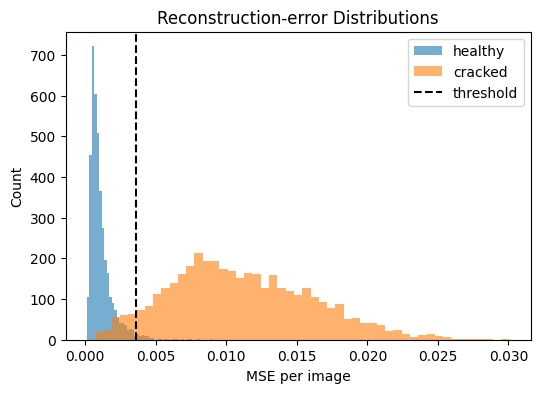

In [11]:
# ——— Reconstruction-Error Distribution ———
plt.figure(figsize=(6,4))
plt.hist([e for e,l in zip(errs,labs) if l==0], bins=50, alpha=0.6, label="healthy")
plt.hist([e for e,l in zip(errs,labs) if l==1], bins=50, alpha=0.6, label="cracked")
plt.axvline(thr, color="k", linestyle="--", label="threshold")
plt.legend()
plt.title("Reconstruction-error Distributions")
plt.xlabel("MSE per image")
plt.ylabel("Count")
plt.show()

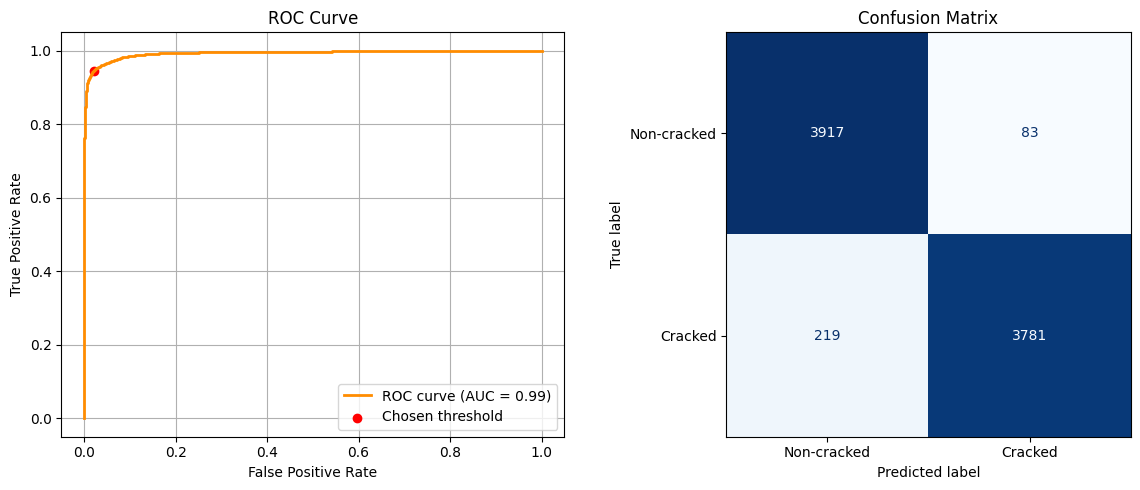

In [12]:
fpr, tpr, thresholds = roc_curve(labs, errs)
closest_idx = np.argmin(np.abs(thresholds - thr))
cm = confusion_matrix(labs, preds)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ——— ROC Curve ———
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {auc:.2f})")
axes[0].scatter(fpr[closest_idx], tpr[closest_idx], color='red', label="Chosen threshold")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve")
axes[0].legend(loc="lower right")
axes[0].grid(True)

# ——— Confusion Matrix ———
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-cracked", "Cracked"])
disp.plot(ax=axes[1], cmap="Blues", colorbar=False)
axes[1].set_title("Confusion Matrix")

plt.tight_layout()
plt.show()

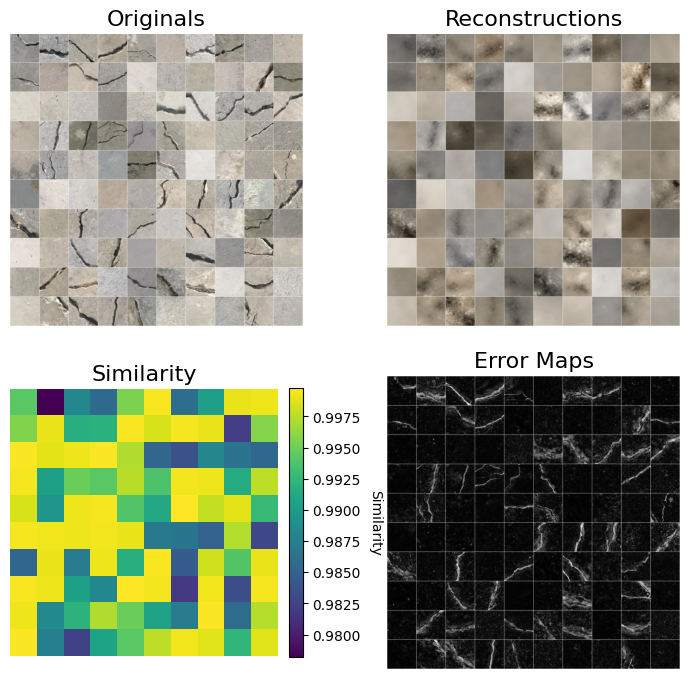

In [13]:
import torchvision.utils as vutils
from matplotlib.colors import Normalize


N = 100         # samples
test_ds = test_loader.dataset
idxs   = random.sample(range(len(test_ds)), N)

imgs, recons, mses = [], [], []

for i in idxs:
    x, _   = test_ds[i]      
    x_dev  = x.unsqueeze(0).to(device) 
    with torch.no_grad():
        recon_dev, _, _ = model(x_dev)
    imgs.append(x_dev.cpu())
    recons.append(recon_dev.cpu())
    # MSE per image
    mse = ((recon_dev - x_dev)**2).view(1,-1).mean().item()
    mses.append(mse)


imgs   = torch.cat(imgs,   dim=0) 
recons = torch.cat(recons, dim=0)

err_map     = (imgs - recons).abs().mean(dim=1, keepdim=True).repeat(1,3,1,1)
# similarity = exp(-mse), normalized
mses_arr    = np.array(mses)
sims        = np.exp(-mses_arr)
sim_arr     = sims.reshape(10,10)

grid_o = vutils.make_grid(imgs,    nrow=10, normalize=True, pad_value=1)
grid_r = vutils.make_grid(recons,  nrow=10, normalize=True, pad_value=1)
grid_e = vutils.make_grid(err_map, nrow=10, normalize=True, pad_value=1)


fig, ax = plt.subplots(2,2, figsize=(7, 7))

ax[0,0].imshow(grid_o.permute(1,2,0))
ax[0,0].set_title("Originals", fontsize=16)
ax[0,0].axis("off")

ax[0,1].imshow(grid_r.permute(1,2,0))
ax[0,1].set_title("Reconstructions", fontsize=16)
ax[0,1].axis("off")

norm = Normalize(vmin=sims.min(), vmax=sims.max())
im2  = ax[1,0].imshow(sim_arr, cmap="viridis", norm=norm)
ax[1,0].set_title("Similarity", fontsize=16)
ax[1,0].axis("off")
cbar2 = fig.colorbar(im2, ax=ax[1,0], fraction=0.046, pad=0.04)
cbar2.set_label("Similarity", rotation=270, labelpad=15)

im = ax[1,1].imshow(grid_e.permute(1,2,0), cmap="hot")
ax[1,1].set_title("Error Maps", fontsize=16)
ax[1,1].axis("off")

plt.tight_layout()
plt.show()

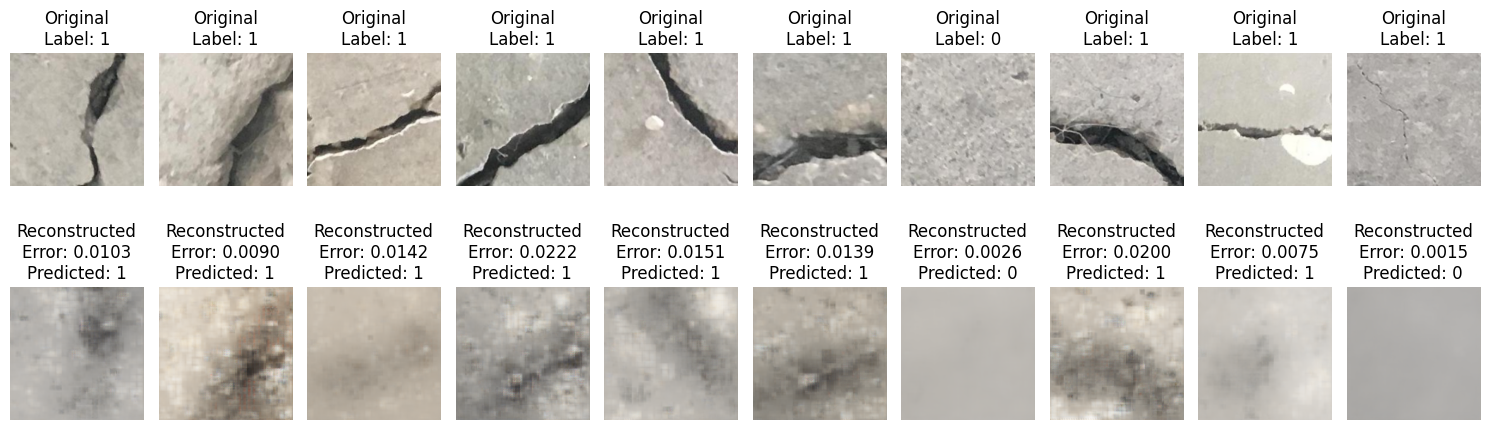

In [17]:
# Function to visualize original and reconstructed images
def visualize_reconstruction(original, reconstructed, errors, labels, num_samples=5):
    indices = random.sample(range(len(original)), num_samples)
    
    plt.figure(figsize=(15, 5))
    
    for i, idx in enumerate(indices):
        ax = plt.subplot(2, num_samples, i + 1)
        plt.imshow(original[idx].cpu().permute(1, 2, 0))  # Original image
        plt.title(f"Original\nLabel: {labels[idx]}")
        plt.axis('off')

        ax = plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(reconstructed[idx].cpu().permute(1, 2, 0))  # Reconstructed image
        predicted_label = 1 if errors[idx] > thr else 0 
        plt.title(f"Reconstructed\nError: {errors[idx]:.4f}\nPredicted: {predicted_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def get_reconstructed_images(test_loader, model, device):
    original_images = []
    reconstructed_images = []
    errors = []
    labels = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device, non_blocking=True)
            recon, _, _ = model(xb)
            mse = ((recon - xb) ** 2).view(xb.size(0), -1).mean(dim=1)
            original_images.extend(xb.cpu())
            reconstructed_images.extend(recon.cpu())
            errors.extend(mse.cpu().numpy().tolist())
            labels.extend(yb.numpy().tolist())

    return original_images, reconstructed_images, errors, labels

original, reconstructed, errors, labels = get_reconstructed_images(test_loader, model, device)

visualize_reconstruction(original, reconstructed, errors, labels, num_samples=10)

## <center>**The End**</center>